In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=1)
output_dir = './output_lambda=0'

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=0.0)

[Info] Training performance will be written to file: ./output_lambda=0/train.log and ./output_lambda=0/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.305 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.320 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.82059, accuracy: 12.160 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8516.91117, accuracy: 13.830 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.26419, accuracy: 13.394 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8463.29928, accuracy: 16.281 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.22838, accuracy: 15.141 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8407.04963, accuracy: 16.468 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.67131, accuracy: 15.923 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8361.96586, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8487.99969, accuracy: 16.344 %, lr:  0.00000, elapse: 0.319 min


  - (Validation) ppl:  8302.44489, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.25904, accuracy: 16.603 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8249.60499, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.79326, accuracy: 16.771 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8197.08365, accuracy: 17.438 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37876, accuracy: 16.919 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8140.12348, accuracy: 17.742 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.55829, accuracy: 16.956 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8090.84421, accuracy: 17.735 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.85978, accuracy: 17.090 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8029.56615, accuracy: 17.722 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.59649, accuracy: 16.939 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7969.87323, accuracy: 18.165 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.78141, accuracy: 17.071 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7912.73221, accuracy: 17.791 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.73859, accuracy: 17.126 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7846.91887, accuracy: 17.922 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.67272, accuracy: 17.044 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7784.88066, accuracy: 17.846 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.36804, accuracy: 17.106 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7722.34267, accuracy: 18.234 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.65298, accuracy: 17.084 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7658.12946, accuracy: 17.445 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.65850, accuracy: 16.970 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7589.41853, accuracy: 18.172 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.40281, accuracy: 17.003 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  7521.63337, accuracy: 18.006 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.61478, accuracy: 16.865 %, lr:  0.00000, elapse: 0.322 min


  - (Validation) ppl:  7453.32042, accuracy: 17.874 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.20749, accuracy: 16.909 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  7384.60903, accuracy: 18.096 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.85985, accuracy: 16.846 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7316.32129, accuracy: 18.518 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.11061, accuracy: 16.635 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  7242.48500, accuracy: 18.130 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.05926, accuracy: 16.544 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  7166.95448, accuracy: 17.265 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.79186, accuracy: 16.474 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  7094.45864, accuracy: 16.150 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.24846, accuracy: 16.419 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  7017.77938, accuracy: 17.403 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.62547, accuracy: 16.521 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6941.94016, accuracy: 17.978 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.13648, accuracy: 16.246 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6864.68988, accuracy: 17.583 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.17250, accuracy: 16.136 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6787.95770, accuracy: 17.680 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.89319, accuracy: 15.996 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6711.40599, accuracy: 17.929 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.67735, accuracy: 15.940 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6630.77582, accuracy: 16.572 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.31786, accuracy: 15.810 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  6551.22244, accuracy: 17.258 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.00149, accuracy: 15.800 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6471.05834, accuracy: 16.669 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.54250, accuracy: 15.662 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  6390.62343, accuracy: 15.997 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.94314, accuracy: 15.370 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6312.22472, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.67258, accuracy: 15.097 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  6228.50834, accuracy: 16.378 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.68339, accuracy: 15.035 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  6146.26636, accuracy: 16.198 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.18789, accuracy: 14.895 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6063.16802, accuracy: 15.616 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.79771, accuracy: 14.714 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5981.10905, accuracy: 15.693 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.99840, accuracy: 14.444 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5898.74511, accuracy: 15.783 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.49039, accuracy: 14.332 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5815.11593, accuracy: 13.712 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.35248, accuracy: 14.174 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5732.42583, accuracy: 14.162 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.23564, accuracy: 13.921 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5648.60835, accuracy: 13.781 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.29326, accuracy: 13.725 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5566.39135, accuracy: 13.089 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.14252, accuracy: 13.431 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5482.22760, accuracy: 13.345 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.82309, accuracy: 13.331 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5398.44697, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.04086, accuracy: 13.147 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5316.54351, accuracy: 12.583 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.49810, accuracy: 12.987 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  5231.67626, accuracy: 12.126 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.94236, accuracy: 12.799 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5148.58016, accuracy: 12.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.04025, accuracy: 12.639 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  5066.74359, accuracy: 12.078 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.74749, accuracy: 12.539 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4984.72026, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.71267, accuracy: 12.502 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  4900.58074, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.50659, accuracy: 12.356 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4818.19512, accuracy: 12.071 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.26667, accuracy: 12.309 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  4736.66529, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.32561, accuracy: 12.248 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4656.05656, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.03905, accuracy: 12.165 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4574.04835, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.27960, accuracy: 12.162 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4493.18677, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.84193, accuracy: 12.085 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4412.28036, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.42838, accuracy: 12.100 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  4333.42039, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.91935, accuracy: 12.058 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  4253.92219, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.05632, accuracy: 12.061 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4175.42267, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.03107, accuracy: 12.046 %, lr:  0.00001, elapse: 0.321 min


  - (Validation) ppl:  4096.23256, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4504.99556, accuracy: 12.032 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4019.27710, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.63286, accuracy: 12.028 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  3942.39567, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.76698, accuracy: 12.023 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3865.93367, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.26726, accuracy: 12.022 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3790.12816, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.12128, accuracy: 12.020 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3715.28342, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4132.99517, accuracy: 12.018 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3640.84591, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.15862, accuracy: 12.018 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3568.20769, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.40931, accuracy: 12.016 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3495.29075, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.88557, accuracy: 12.016 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  3423.90835, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.96262, accuracy: 12.016 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3352.49972, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.59006, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3282.32377, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.56481, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3212.97439, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.60358, accuracy: 12.016 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  3144.20809, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.02931, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  3076.85613, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.36556, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3009.59677, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.21294, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2945.71635, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.22548, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2879.05794, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.77290, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2814.80097, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.36419, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2751.90519, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.83148, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2690.23576, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.16796, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2628.46680, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3046.99859, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  2568.63718, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.64132, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2508.17246, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.79443, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2450.28281, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.00404, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  2392.96271, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.09569, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2336.73570, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.87627, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2280.90599, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.55449, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  2227.04626, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.43878, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2173.15758, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.61261, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2121.40711, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.92395, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2069.81032, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.08410, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2018.05022, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.12541, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1968.91987, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.01905, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1920.43901, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.51909, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  1872.00404, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.41478, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1824.57443, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.69914, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1779.09955, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.19257, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1734.27665, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.39628, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1689.47025, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.44336, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1646.61058, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.18395, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  1604.31559, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.31558, accuracy: 12.015 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  1563.56669, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.83485, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1523.08502, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.54102, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  1483.50976, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.58656, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1444.65913, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1807.00747, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1407.79558, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.89904, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1370.28375, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.81100, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1334.55788, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.50850, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1299.10260, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1648.07468, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1264.81677, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.41193, accuracy: 12.015 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  1231.69801, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.45057, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1199.42568, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.51820, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1167.35518, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.13347, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1135.98823, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.51831, accuracy: 12.015 %, lr:  0.00002, elapse: 0.322 min


  - (Validation) ppl:  1106.11023, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.86124, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1076.64054, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1400.97982, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1047.67595, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.64799, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  1019.75124, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1336.99749, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  992.69758, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.38772, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  966.09268, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.11694, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  939.94371, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.80741, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  915.29077, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.16832, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  890.51636, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.11982, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  866.56793, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.74191, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  843.16454, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.10411, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  820.75059, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.27056, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  798.89098, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.82486, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  777.54963, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.11747, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  756.93337, accuracy: 11.988 %, lr:  0.00002, elapse: 0.008 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.02351, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  736.59967, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.61557, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  717.21739, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.70458, accuracy: 12.015 %, lr:  0.00002, elapse: 0.307 min


  - (Validation) ppl:  698.17777, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.42819, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  679.67704, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.80586, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  661.79311, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.65222, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  644.40451, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.17765, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  627.60944, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.25508, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  611.38540, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.83099, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  595.38761, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.95197, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  579.95384, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.62726, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  565.10525, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.77384, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  550.78907, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.50343, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  536.78331, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.73149, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  523.23601, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.38642, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  510.09450, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.49628, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  497.47264, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.11247, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  485.18396, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.23612, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  473.28666, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.73913, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  461.77902, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.63539, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  450.66698, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.03957, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  439.95728, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.81400, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  429.52544, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  644.98497, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  419.47324, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.59406, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  409.67635, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.56139, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  400.26958, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.94020, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  391.31658, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.64436, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  382.42571, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.71168, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  373.93131, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.15242, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  365.77666, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.97058, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  357.89819, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.12323, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  350.23754, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.61989, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  342.97190, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.40722, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  335.85635, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.54169, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  329.09000, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.02133, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  322.44819, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.79885, accuracy: 12.015 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  316.12886, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.87900, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  310.06419, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.28098, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  304.22243, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.01621, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  298.61373, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.05875, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  293.28347, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.38161, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  288.18811, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.00258, accuracy: 12.015 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  283.27790, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.84863, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  278.49292, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.93893, accuracy: 12.015 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  274.03618, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.24807, accuracy: 12.016 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  269.58053, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.80058, accuracy: 12.021 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  265.47970, accuracy: 12.001 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.42865, accuracy: 12.025 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  261.36360, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.17463, accuracy: 12.055 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  257.39125, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.11164, accuracy: 12.090 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  253.59333, accuracy: 12.029 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.14791, accuracy: 12.116 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  250.30768, accuracy: 12.147 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.48599, accuracy: 12.171 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  246.41082, accuracy: 12.181 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.72500, accuracy: 12.218 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  243.45185, accuracy: 12.091 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.30224, accuracy: 12.238 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  239.96656, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  406.86420, accuracy: 12.289 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  236.58211, accuracy: 12.126 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.45426, accuracy: 12.307 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  233.39713, accuracy: 12.195 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.40576, accuracy: 12.317 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  230.69301, accuracy: 12.154 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.13750, accuracy: 12.363 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  226.94436, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.07233, accuracy: 12.387 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  223.90638, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.20804, accuracy: 12.360 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  221.54925, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.56671, accuracy: 12.365 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  217.84668, accuracy: 12.001 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.34809, accuracy: 12.383 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  215.59602, accuracy: 12.029 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.56770, accuracy: 12.420 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  212.56828, accuracy: 12.043 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  370.84517, accuracy: 12.475 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  210.64003, accuracy: 12.022 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.18853, accuracy: 12.502 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  208.37267, accuracy: 12.334 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.41878, accuracy: 12.605 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  205.25394, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  359.80697, accuracy: 12.743 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  203.32515, accuracy: 12.368 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.23050, accuracy: 12.918 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  201.43017, accuracy: 12.472 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.34409, accuracy: 13.172 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  198.22405, accuracy: 13.068 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  348.99138, accuracy: 13.391 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  194.84819, accuracy: 12.825 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.09652, accuracy: 13.730 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  193.80198, accuracy: 14.169 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.37608, accuracy: 14.050 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  189.97291, accuracy: 13.220 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.64684, accuracy: 14.332 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  187.98226, accuracy: 14.349 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.05470, accuracy: 14.782 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  185.99219, accuracy: 15.519 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.08209, accuracy: 15.135 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  182.95115, accuracy: 13.892 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.28341, accuracy: 15.472 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  180.87215, accuracy: 14.404 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.53954, accuracy: 15.912 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  179.03332, accuracy: 16.136 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.81044, accuracy: 16.307 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  176.03724, accuracy: 15.602 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  314.92690, accuracy: 16.598 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  173.41857, accuracy: 15.949 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.05918, accuracy: 17.118 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  170.72863, accuracy: 17.479 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.37316, accuracy: 17.598 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  169.54272, accuracy: 17.909 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.33791, accuracy: 18.955 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  166.38504, accuracy: 17.472 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.67788, accuracy: 20.345 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  163.30870, accuracy: 17.133 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  295.95082, accuracy: 22.157 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  161.47579, accuracy: 23.885 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.34677, accuracy: 23.174 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  158.49232, accuracy: 24.702 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.31606, accuracy: 24.439 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  156.27502, accuracy: 24.418 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  284.64611, accuracy: 24.555 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  154.28574, accuracy: 24.515 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.12994, accuracy: 24.749 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  151.24286, accuracy: 24.584 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.37809, accuracy: 24.789 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  150.48032, accuracy: 24.868 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.40870, accuracy: 24.828 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  147.64827, accuracy: 24.751 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  269.88585, accuracy: 24.890 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  146.14496, accuracy: 25.028 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.38595, accuracy: 24.964 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  143.22365, accuracy: 24.889 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.88531, accuracy: 25.083 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  139.59433, accuracy: 25.159 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.01458, accuracy: 25.280 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  138.81273, accuracy: 25.409 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.18132, accuracy: 25.715 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  136.93615, accuracy: 26.101 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  251.98344, accuracy: 26.243 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  134.47580, accuracy: 27.943 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.50967, accuracy: 26.912 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  133.79189, accuracy: 28.262 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  244.88335, accuracy: 27.443 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  130.49470, accuracy: 28.283 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.51405, accuracy: 27.819 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  130.02488, accuracy: 28.109 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.33481, accuracy: 28.052 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  125.68058, accuracy: 28.490 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.56907, accuracy: 28.288 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  122.81972, accuracy: 28.428 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.26969, accuracy: 28.372 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  121.47722, accuracy: 28.449 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  227.85502, accuracy: 28.460 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  119.85542, accuracy: 28.546 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  224.73750, accuracy: 28.571 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  117.09373, accuracy: 28.608 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.52585, accuracy: 28.627 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  115.12292, accuracy: 28.677 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.15531, accuracy: 28.669 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  113.57634, accuracy: 28.712 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.56764, accuracy: 28.679 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  110.93823, accuracy: 28.747 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.34089, accuracy: 28.738 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  110.20615, accuracy: 28.719 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.21446, accuracy: 28.759 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  108.28187, accuracy: 28.670 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.07489, accuracy: 28.823 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  106.58216, accuracy: 28.871 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.15448, accuracy: 28.852 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  106.33541, accuracy: 28.809 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  200.62595, accuracy: 28.860 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  102.98079, accuracy: 28.885 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  197.68977, accuracy: 28.915 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  100.80652, accuracy: 28.947 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.29251, accuracy: 28.909 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  99.88766, accuracy: 28.940 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.28923, accuracy: 28.977 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  98.36828, accuracy: 29.051 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  189.95467, accuracy: 28.988 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  97.17431, accuracy: 28.975 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  187.04026, accuracy: 29.045 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  95.30875, accuracy: 29.100 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.50805, accuracy: 29.064 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  93.90589, accuracy: 29.155 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.47720, accuracy: 29.069 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  92.79191, accuracy: 29.093 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.05128, accuracy: 29.102 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  90.86805, accuracy: 28.982 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.85548, accuracy: 29.123 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  89.41724, accuracy: 29.176 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.40956, accuracy: 29.171 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  88.40032, accuracy: 29.287 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  172.93317, accuracy: 29.223 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  87.54197, accuracy: 29.294 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  170.89836, accuracy: 29.247 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  85.71077, accuracy: 29.231 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  168.84765, accuracy: 29.260 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  84.64748, accuracy: 29.467 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  166.62236, accuracy: 29.314 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  83.72726, accuracy: 29.411 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  164.66788, accuracy: 29.393 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  82.22491, accuracy: 29.661 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.61970, accuracy: 29.500 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  80.90810, accuracy: 29.446 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  160.91380, accuracy: 29.554 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  81.20594, accuracy: 29.716 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 282 ]


  - (Training)   ppl:  158.81366, accuracy: 29.659 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  78.44218, accuracy: 29.785 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.07916, accuracy: 29.749 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  78.17934, accuracy: 29.751 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.48584, accuracy: 29.813 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  77.02297, accuracy: 30.090 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.57874, accuracy: 29.922 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  76.46676, accuracy: 30.215 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.08235, accuracy: 29.975 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  75.54257, accuracy: 30.312 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.27533, accuracy: 30.057 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  74.17488, accuracy: 30.055 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.63273, accuracy: 30.138 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  73.11656, accuracy: 30.194 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.14256, accuracy: 30.217 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  72.33865, accuracy: 30.388 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.37909, accuracy: 30.309 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  71.20773, accuracy: 30.332 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  143.91060, accuracy: 30.400 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  71.25969, accuracy: 30.623 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 292 ]


  - (Training)   ppl:  142.50658, accuracy: 30.475 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  69.64649, accuracy: 30.637 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.09574, accuracy: 30.593 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  68.68309, accuracy: 30.665 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.55416, accuracy: 30.677 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  67.70771, accuracy: 30.568 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.40579, accuracy: 30.807 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  67.63923, accuracy: 30.623 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  136.89331, accuracy: 30.876 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  66.37781, accuracy: 30.859 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  135.81512, accuracy: 30.970 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  65.74950, accuracy: 30.886 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.25449, accuracy: 31.115 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  65.12370, accuracy: 31.080 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.04200, accuracy: 31.212 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  64.14192, accuracy: 31.080 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  131.92530, accuracy: 31.305 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  63.74012, accuracy: 31.247 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  131.01516, accuracy: 31.375 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  62.74687, accuracy: 31.648 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.45859, accuracy: 31.535 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  62.14660, accuracy: 31.676 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  128.57395, accuracy: 31.621 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  61.97650, accuracy: 31.766 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.30387, accuracy: 31.745 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  61.64362, accuracy: 31.953 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.41107, accuracy: 31.812 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  60.69116, accuracy: 32.078 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  124.85754, accuracy: 31.993 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  59.93546, accuracy: 32.341 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  123.99750, accuracy: 32.080 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  59.79809, accuracy: 32.514 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.03279, accuracy: 32.129 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  59.15176, accuracy: 32.528 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  122.23500, accuracy: 32.249 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  58.67704, accuracy: 32.424 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  120.88314, accuracy: 32.370 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  58.02107, accuracy: 32.701 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  119.68734, accuracy: 32.485 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  57.04821, accuracy: 32.735 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  118.98874, accuracy: 32.537 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  56.79532, accuracy: 32.742 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.26270, accuracy: 32.565 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  55.86546, accuracy: 32.839 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.18251, accuracy: 32.707 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  56.12428, accuracy: 32.902 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.39190, accuracy: 32.760 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  55.72287, accuracy: 32.999 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.53418, accuracy: 32.832 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  54.88050, accuracy: 33.151 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  114.44169, accuracy: 32.944 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  54.09841, accuracy: 33.172 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.00630, accuracy: 32.927 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  53.59847, accuracy: 33.234 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  112.88892, accuracy: 33.088 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  53.15727, accuracy: 33.470 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.21388, accuracy: 33.142 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  53.38175, accuracy: 33.407 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  111.29931, accuracy: 33.259 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  52.76784, accuracy: 33.657 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  110.96525, accuracy: 33.281 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  52.24137, accuracy: 33.947 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  109.71367, accuracy: 33.521 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  51.57822, accuracy: 33.954 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  108.99876, accuracy: 33.579 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  51.22807, accuracy: 34.141 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.23921, accuracy: 33.682 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  50.84546, accuracy: 34.127 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.61570, accuracy: 33.764 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  50.56408, accuracy: 34.003 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  106.71941, accuracy: 33.892 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  50.11914, accuracy: 34.252 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.04355, accuracy: 33.994 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  49.65022, accuracy: 34.481 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 329 ]


  - (Training)   ppl:  105.18194, accuracy: 34.069 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  49.50997, accuracy: 34.543 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  105.01319, accuracy: 34.043 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  49.08270, accuracy: 34.806 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  103.96632, accuracy: 34.220 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  48.99292, accuracy: 34.668 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  103.20266, accuracy: 34.289 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  48.25681, accuracy: 34.841 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.54979, accuracy: 34.366 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  47.90391, accuracy: 35.069 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 334 ]


  - (Training)   ppl:  102.18421, accuracy: 34.363 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  47.90616, accuracy: 34.993 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 335 ]


  - (Training)   ppl:  101.35324, accuracy: 34.506 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  47.23824, accuracy: 35.166 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  100.79960, accuracy: 34.580 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  47.37599, accuracy: 35.194 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 337 ]


  - (Training)   ppl:  100.05272, accuracy: 34.680 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  46.29096, accuracy: 35.409 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.35161, accuracy: 34.787 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  46.18453, accuracy: 35.499 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  98.83691, accuracy: 34.831 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  45.64998, accuracy: 35.506 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.20554, accuracy: 34.927 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  45.69020, accuracy: 35.554 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 341 ]


  - (Training)   ppl:  97.66111, accuracy: 35.044 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  45.11567, accuracy: 35.658 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  96.94641, accuracy: 35.164 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  44.86709, accuracy: 35.852 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 343 ]


  - (Training)   ppl:  96.50541, accuracy: 35.282 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  44.40950, accuracy: 35.741 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  95.54168, accuracy: 35.425 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  44.40247, accuracy: 35.900 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 345 ]


  - (Training)   ppl:  94.96989, accuracy: 35.467 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  43.76501, accuracy: 35.852 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  94.33410, accuracy: 35.528 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  43.75480, accuracy: 36.011 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  93.86069, accuracy: 35.567 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  43.06639, accuracy: 36.129 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  93.55438, accuracy: 35.623 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  42.92607, accuracy: 36.184 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  93.13227, accuracy: 35.659 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.36373, accuracy: 36.406 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.36806, accuracy: 35.730 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.77085, accuracy: 36.129 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 351 ]


  - (Training)   ppl:  91.53858, accuracy: 35.895 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  42.15184, accuracy: 36.253 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.00265, accuracy: 35.885 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  41.79296, accuracy: 36.212 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  90.46617, accuracy: 35.981 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  41.35983, accuracy: 36.406 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  89.87147, accuracy: 36.029 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  41.50917, accuracy: 36.614 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 355 ]


  - (Training)   ppl:  89.21838, accuracy: 36.128 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  41.02829, accuracy: 36.662 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  88.54728, accuracy: 36.156 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  40.18561, accuracy: 36.620 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  87.94669, accuracy: 36.232 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  40.00936, accuracy: 36.738 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  87.47229, accuracy: 36.279 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  40.20219, accuracy: 36.759 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 359 ]


  - (Training)   ppl:  87.13383, accuracy: 36.211 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  39.39743, accuracy: 36.780 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  86.42626, accuracy: 36.323 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  39.17855, accuracy: 36.835 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  85.66600, accuracy: 36.475 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  38.65750, accuracy: 36.634 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  85.18616, accuracy: 36.566 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  38.76534, accuracy: 36.994 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 363 ]


  - (Training)   ppl:  84.50106, accuracy: 36.697 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  38.11782, accuracy: 37.458 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  83.80696, accuracy: 36.911 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  37.82984, accuracy: 37.431 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  83.52921, accuracy: 36.944 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  37.68570, accuracy: 37.742 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  83.09328, accuracy: 37.051 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  37.32827, accuracy: 37.756 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  82.33548, accuracy: 37.241 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  37.31319, accuracy: 37.881 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  82.35837, accuracy: 37.196 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  36.84954, accuracy: 37.756 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  81.55962, accuracy: 37.410 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  36.56259, accuracy: 37.846 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  81.24835, accuracy: 37.407 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.61891, accuracy: 37.735 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 371 ]


  - (Training)   ppl:  80.54855, accuracy: 37.565 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  36.40614, accuracy: 37.936 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  80.11098, accuracy: 37.684 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.71423, accuracy: 37.936 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 373 ]


  - (Training)   ppl:  79.68439, accuracy: 37.764 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  35.87184, accuracy: 38.165 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  79.41255, accuracy: 37.712 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.99211, accuracy: 38.033 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 375 ]


  - (Training)   ppl:  78.88220, accuracy: 37.834 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  35.65019, accuracy: 38.130 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  78.47321, accuracy: 37.957 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.58438, accuracy: 38.594 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  77.74626, accuracy: 38.095 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  35.17645, accuracy: 38.172 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  77.37993, accuracy: 38.162 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  35.02251, accuracy: 38.428 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  77.12275, accuracy: 38.186 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  34.52875, accuracy: 38.913 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  76.46837, accuracy: 38.380 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.41104, accuracy: 39.037 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  76.30562, accuracy: 38.344 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.34400, accuracy: 38.657 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  75.48176, accuracy: 38.550 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.14830, accuracy: 39.190 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  75.21002, accuracy: 38.597 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  33.47360, accuracy: 39.307 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  74.60879, accuracy: 38.778 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  33.38500, accuracy: 39.522 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  74.08736, accuracy: 38.860 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.47035, accuracy: 39.349 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 386 ]


  - (Training)   ppl:  73.99842, accuracy: 38.894 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  33.03554, accuracy: 39.460 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  73.72913, accuracy: 38.880 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  32.95062, accuracy: 39.598 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 388 ]


  - (Training)   ppl:  73.40520, accuracy: 38.958 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  33.51369, accuracy: 39.529 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  72.88501, accuracy: 39.065 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  32.68992, accuracy: 39.903 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  72.38285, accuracy: 39.221 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  32.63357, accuracy: 40.048 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  72.11100, accuracy: 39.211 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.16003, accuracy: 40.000 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 392 ]


  - (Training)   ppl:  71.20419, accuracy: 39.491 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.06541, accuracy: 39.938 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 393 ]


  - (Training)   ppl:  71.10510, accuracy: 39.467 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  31.76009, accuracy: 40.097 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  70.63105, accuracy: 39.617 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.53671, accuracy: 40.069 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  70.08744, accuracy: 39.700 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  31.47374, accuracy: 40.374 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 396 ]


  - (Training)   ppl:  69.83972, accuracy: 39.749 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  30.93058, accuracy: 40.596 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  69.28614, accuracy: 39.949 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.74781, accuracy: 40.519 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 398 ]


  - (Training)   ppl:  68.96790, accuracy: 39.939 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  30.75293, accuracy: 40.686 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 399 ]


  - (Training)   ppl:  68.95362, accuracy: 39.899 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  30.93131, accuracy: 40.900 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 400 ]


  - (Training)   ppl:  68.26469, accuracy: 40.171 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.47594, accuracy: 40.547 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 401 ]


  - (Training)   ppl:  68.05600, accuracy: 40.124 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.60678, accuracy: 40.845 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 402 ]


  - (Training)   ppl:  67.65694, accuracy: 40.300 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  30.16327, accuracy: 41.011 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  67.15254, accuracy: 40.393 %, lr:  0.00004, elapse: 0.321 min


  - (Validation) ppl:  29.86320, accuracy: 41.150 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  66.81839, accuracy: 40.486 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  29.38511, accuracy: 41.170 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  66.34722, accuracy: 40.604 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  29.96014, accuracy: 41.032 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  66.09204, accuracy: 40.647 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  29.30828, accuracy: 41.385 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  65.60966, accuracy: 40.797 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  29.00458, accuracy: 41.427 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  65.24490, accuracy: 40.917 %, lr:  0.00004, elapse: 0.306 min


  - (Validation) ppl:  29.26219, accuracy: 41.316 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 409 ]


  - (Training)   ppl:  65.12269, accuracy: 40.858 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.82605, accuracy: 41.309 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  64.70875, accuracy: 40.962 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.62148, accuracy: 41.530 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  64.17183, accuracy: 41.161 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.42283, accuracy: 41.717 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  64.08181, accuracy: 41.161 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.40725, accuracy: 41.551 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 413 ]


  - (Training)   ppl:  63.79639, accuracy: 41.169 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  28.74930, accuracy: 41.295 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 414 ]


  - (Training)   ppl:  63.56872, accuracy: 41.295 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.28372, accuracy: 41.607 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  62.67403, accuracy: 41.556 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  27.90515, accuracy: 41.620 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  62.73423, accuracy: 41.471 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.00176, accuracy: 41.835 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  62.47586, accuracy: 41.534 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  27.53464, accuracy: 41.911 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  62.07265, accuracy: 41.649 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.87928, accuracy: 41.537 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 419 ]


  - (Training)   ppl:  61.74842, accuracy: 41.739 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  27.29030, accuracy: 42.105 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  61.43983, accuracy: 41.853 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.16308, accuracy: 42.265 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  60.90766, accuracy: 42.033 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.36787, accuracy: 42.071 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  60.79151, accuracy: 42.012 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.80772, accuracy: 42.424 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  60.29971, accuracy: 42.197 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.66737, accuracy: 42.341 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  60.25072, accuracy: 42.138 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  26.50016, accuracy: 42.479 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  59.68672, accuracy: 42.342 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  26.20426, accuracy: 42.632 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  59.29659, accuracy: 42.399 %, lr:  0.00005, elapse: 0.307 min


  - (Validation) ppl:  26.36412, accuracy: 42.431 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  59.20320, accuracy: 42.436 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.03624, accuracy: 42.957 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  58.74903, accuracy: 42.588 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  26.08068, accuracy: 42.535 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 429 ]


  - (Training)   ppl:  58.50555, accuracy: 42.674 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.89204, accuracy: 42.770 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 430 ]


  - (Training)   ppl:  58.09603, accuracy: 42.758 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.83535, accuracy: 42.860 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  57.87420, accuracy: 42.784 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  25.62175, accuracy: 42.846 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  57.27143, accuracy: 43.034 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  25.49752, accuracy: 43.082 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  57.24955, accuracy: 43.036 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.75987, accuracy: 42.708 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  56.97544, accuracy: 43.103 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.46710, accuracy: 43.324 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 435 ]


  - (Training)   ppl:  56.78476, accuracy: 43.228 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  25.03370, accuracy: 43.283 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  56.15764, accuracy: 43.412 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  25.35637, accuracy: 42.978 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 437 ]


  - (Training)   ppl:  55.78406, accuracy: 43.489 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.85402, accuracy: 43.483 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  55.56446, accuracy: 43.620 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  24.46723, accuracy: 44.065 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  55.19244, accuracy: 43.793 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  24.75909, accuracy: 43.490 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 440 ]


  - (Training)   ppl:  54.98681, accuracy: 43.854 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  24.07647, accuracy: 43.968 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  54.50909, accuracy: 43.969 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.15317, accuracy: 44.093 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  54.44137, accuracy: 44.030 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.24499, accuracy: 43.968 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 443 ]


  - (Training)   ppl:  53.78129, accuracy: 44.260 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.72568, accuracy: 44.896 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  53.66144, accuracy: 44.303 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.37388, accuracy: 44.640 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  53.37453, accuracy: 44.426 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.71387, accuracy: 44.398 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  52.89927, accuracy: 44.581 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.41633, accuracy: 44.488 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  52.43924, accuracy: 44.712 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  23.17524, accuracy: 44.827 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  52.36523, accuracy: 44.722 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.95596, accuracy: 45.028 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  51.97162, accuracy: 44.883 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  23.08802, accuracy: 44.917 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 450 ]


  - (Training)   ppl:  51.56218, accuracy: 45.014 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  22.48867, accuracy: 45.436 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  51.25018, accuracy: 45.190 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.57929, accuracy: 45.416 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  51.04479, accuracy: 45.222 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  22.51111, accuracy: 45.499 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  50.49301, accuracy: 45.471 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.92515, accuracy: 46.150 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  50.28867, accuracy: 45.519 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.81962, accuracy: 46.039 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  49.89187, accuracy: 45.658 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.03192, accuracy: 45.637 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  49.39864, accuracy: 45.907 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  21.61738, accuracy: 46.302 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  49.08574, accuracy: 46.006 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  21.62627, accuracy: 46.454 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 458 ]


  - (Training)   ppl:  48.80374, accuracy: 46.180 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.49878, accuracy: 46.773 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 459 ]


  - (Training)   ppl:  48.56157, accuracy: 46.186 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  21.24069, accuracy: 46.731 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  47.92132, accuracy: 46.496 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  21.08424, accuracy: 46.717 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 461 ]


  - (Training)   ppl:  47.59396, accuracy: 46.616 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  20.80437, accuracy: 46.967 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  47.29263, accuracy: 46.698 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  20.76067, accuracy: 46.988 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 463 ]


  - (Training)   ppl:  47.04549, accuracy: 46.823 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.81836, accuracy: 46.891 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 464 ]


  - (Training)   ppl:  46.61944, accuracy: 46.968 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  20.28757, accuracy: 47.105 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  46.59117, accuracy: 46.985 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  20.59988, accuracy: 47.216 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 466 ]


  - (Training)   ppl:  46.16809, accuracy: 47.214 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  20.04935, accuracy: 47.507 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  45.67707, accuracy: 47.384 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  19.82313, accuracy: 47.722 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  45.24280, accuracy: 47.628 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  19.96339, accuracy: 47.458 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  45.11080, accuracy: 47.659 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  19.59530, accuracy: 47.860 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 470 ]


  - (Training)   ppl:  44.58613, accuracy: 47.843 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  19.39713, accuracy: 47.936 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 471 ]


  - (Training)   ppl:  44.16793, accuracy: 48.017 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  19.27312, accuracy: 48.089 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  43.95338, accuracy: 48.136 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  19.08807, accuracy: 48.636 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  43.47755, accuracy: 48.360 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  18.81484, accuracy: 48.823 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 474 ]


  - (Training)   ppl:  43.51235, accuracy: 48.251 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.66041, accuracy: 48.698 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  43.08147, accuracy: 48.536 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  18.66210, accuracy: 49.051 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 476 ]


  - (Training)   ppl:  42.68837, accuracy: 48.732 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  18.59067, accuracy: 48.989 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 477 ]


  - (Training)   ppl:  42.05518, accuracy: 49.005 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.44638, accuracy: 48.982 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  42.11298, accuracy: 49.031 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  18.19800, accuracy: 49.280 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  41.38410, accuracy: 49.369 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  17.74792, accuracy: 49.723 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  41.15688, accuracy: 49.421 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  17.67839, accuracy: 49.827 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  40.79941, accuracy: 49.624 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  17.50933, accuracy: 50.055 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 482 ]


  - (Training)   ppl:  40.42136, accuracy: 49.826 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  17.34998, accuracy: 49.924 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  40.00154, accuracy: 50.092 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.06931, accuracy: 50.547 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  39.76989, accuracy: 50.172 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.01249, accuracy: 50.762 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 485 ]


  - (Training)   ppl:  39.53170, accuracy: 50.301 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.84535, accuracy: 50.755 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 486 ]


  - (Training)   ppl:  39.10184, accuracy: 50.542 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  16.65101, accuracy: 51.212 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  38.65882, accuracy: 50.786 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  16.41520, accuracy: 51.267 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  38.26222, accuracy: 50.996 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  16.23213, accuracy: 51.607 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  37.84298, accuracy: 51.196 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.14967, accuracy: 51.544 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  37.84618, accuracy: 51.208 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.06959, accuracy: 51.565 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 491 ]


  - (Training)   ppl:  37.55627, accuracy: 51.312 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  15.94655, accuracy: 51.766 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  36.96688, accuracy: 51.672 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.00843, accuracy: 52.050 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 493 ]


  - (Training)   ppl:  36.74458, accuracy: 51.762 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  15.67513, accuracy: 52.368 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 494 ]


  - (Training)   ppl:  36.33337, accuracy: 51.980 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  15.31188, accuracy: 52.548 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  36.01529, accuracy: 52.178 %, lr:  0.00005, elapse: 0.320 min


  - (Validation) ppl:  15.41703, accuracy: 52.535 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 496 ]


  - (Training)   ppl:  35.68216, accuracy: 52.365 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  15.29449, accuracy: 52.590 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  35.37393, accuracy: 52.556 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  15.45755, accuracy: 51.766 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 498 ]


  - (Training)   ppl:  35.22771, accuracy: 52.632 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  15.31989, accuracy: 52.583 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 499 ]


  - (Training)   ppl:  34.63965, accuracy: 52.930 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  15.00937, accuracy: 52.805 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  34.64193, accuracy: 52.882 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  14.91198, accuracy: 52.999 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 501 ]


  - (Training)   ppl:  34.09005, accuracy: 53.276 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  14.56170, accuracy: 53.463 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  33.86272, accuracy: 53.408 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  14.46234, accuracy: 53.677 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 503 ]


  - (Training)   ppl:  33.51560, accuracy: 53.645 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.04446, accuracy: 54.398 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  33.05068, accuracy: 53.899 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  14.21994, accuracy: 53.878 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 505 ]


  - (Training)   ppl:  32.89321, accuracy: 54.027 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.38114, accuracy: 53.670 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  32.59974, accuracy: 54.158 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  13.75572, accuracy: 54.363 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  32.42818, accuracy: 54.340 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.73574, accuracy: 54.190 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 508 ]


  - (Training)   ppl:  32.01813, accuracy: 54.542 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  13.73476, accuracy: 54.647 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 509 ]


  - (Training)   ppl:  31.67256, accuracy: 54.824 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.49208, accuracy: 54.785 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  31.50146, accuracy: 54.891 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.60092, accuracy: 54.578 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 511 ]


  - (Training)   ppl:  31.15466, accuracy: 55.095 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  13.31015, accuracy: 55.159 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  31.10725, accuracy: 55.122 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.21962, accuracy: 55.443 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  30.75970, accuracy: 55.342 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  13.07043, accuracy: 55.312 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  30.32252, accuracy: 55.614 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  12.81304, accuracy: 55.409 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  29.99280, accuracy: 55.888 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.91524, accuracy: 55.526 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 516 ]


  - (Training)   ppl:  29.75198, accuracy: 55.982 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  12.77917, accuracy: 55.312 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  29.54645, accuracy: 56.124 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.62789, accuracy: 55.783 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 518 ]


  - (Training)   ppl:  29.44372, accuracy: 56.184 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  12.50229, accuracy: 56.309 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  29.05819, accuracy: 56.449 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.38184, accuracy: 56.226 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 520 ]


  - (Training)   ppl:  28.69793, accuracy: 56.692 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.16256, accuracy: 56.440 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  28.50431, accuracy: 56.771 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  12.08597, accuracy: 56.530 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  28.42607, accuracy: 56.781 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.29534, accuracy: 56.316 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  27.94977, accuracy: 57.202 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.82355, accuracy: 56.953 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  27.71925, accuracy: 57.351 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.94100, accuracy: 56.925 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  27.40299, accuracy: 57.525 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  11.94233, accuracy: 56.711 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  27.34482, accuracy: 57.609 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.74487, accuracy: 56.904 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 527 ]


  - (Training)   ppl:  27.17375, accuracy: 57.706 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.49709, accuracy: 57.348 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 528 ]


  - (Training)   ppl:  26.80403, accuracy: 57.938 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.82736, accuracy: 56.676 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  26.65081, accuracy: 58.167 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  11.49280, accuracy: 57.472 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  26.33074, accuracy: 58.330 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.20001, accuracy: 57.548 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  26.28074, accuracy: 58.332 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.44357, accuracy: 57.472 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  26.01287, accuracy: 58.545 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  11.08209, accuracy: 57.943 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  25.71076, accuracy: 58.768 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  11.09408, accuracy: 58.061 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 534 ]


  - (Training)   ppl:  25.55739, accuracy: 58.891 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.09790, accuracy: 58.144 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 535 ]


  - (Training)   ppl:  25.25939, accuracy: 59.120 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.96476, accuracy: 58.359 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  24.96684, accuracy: 59.376 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.88308, accuracy: 58.428 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 537 ]


  - (Training)   ppl:  24.77289, accuracy: 59.540 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.76554, accuracy: 58.781 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  24.66699, accuracy: 59.567 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.75576, accuracy: 58.615 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  24.55523, accuracy: 59.661 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.60945, accuracy: 58.954 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 540 ]


  - (Training)   ppl:  24.25609, accuracy: 59.934 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.48086, accuracy: 58.920 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  24.06504, accuracy: 60.061 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.49503, accuracy: 58.857 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  23.84339, accuracy: 60.235 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  10.39074, accuracy: 59.266 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  23.64273, accuracy: 60.384 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  10.25359, accuracy: 59.134 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 544 ]


  - (Training)   ppl:  23.41970, accuracy: 60.606 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.29221, accuracy: 59.391 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 545 ]


  - (Training)   ppl:  23.25727, accuracy: 60.704 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.40320, accuracy: 59.183 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 546 ]


  - (Training)   ppl:  23.10108, accuracy: 60.825 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  10.10384, accuracy: 59.709 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  22.89553, accuracy: 61.008 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.14704, accuracy: 59.370 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  22.72061, accuracy: 61.143 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.02396, accuracy: 59.820 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  22.43520, accuracy: 61.343 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.03809, accuracy: 59.938 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 550 ]


  - (Training)   ppl:  22.33722, accuracy: 61.500 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.97567, accuracy: 59.882 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  22.10330, accuracy: 61.685 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.81869, accuracy: 60.055 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  22.00604, accuracy: 61.717 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.85536, accuracy: 59.896 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  21.73602, accuracy: 61.972 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.71996, accuracy: 60.229 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  21.57933, accuracy: 62.116 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.95007, accuracy: 59.744 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  21.46000, accuracy: 62.192 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.55363, accuracy: 60.416 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  21.24322, accuracy: 62.401 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.59827, accuracy: 60.436 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  21.05767, accuracy: 62.490 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.48556, accuracy: 60.526 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  21.12011, accuracy: 62.452 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.52329, accuracy: 60.789 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 559 ]


  - (Training)   ppl:  20.78159, accuracy: 62.773 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.41629, accuracy: 60.880 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  20.71530, accuracy: 62.833 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.34331, accuracy: 60.679 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  20.47889, accuracy: 63.054 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.42481, accuracy: 60.803 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  20.33889, accuracy: 63.197 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.24880, accuracy: 60.956 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 563 ]


  - (Training)   ppl:  20.20111, accuracy: 63.343 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.20186, accuracy: 61.080 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  20.07276, accuracy: 63.453 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.25835, accuracy: 60.990 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  19.89121, accuracy: 63.592 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.09798, accuracy: 61.219 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  19.65463, accuracy: 63.819 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  9.05561, accuracy: 61.683 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 567 ]


  - (Training)   ppl:  19.56479, accuracy: 63.877 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.00781, accuracy: 61.503 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  19.45099, accuracy: 64.007 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.00192, accuracy: 61.454 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 569 ]


  - (Training)   ppl:  19.33586, accuracy: 64.131 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.99674, accuracy: 61.302 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 570 ]


  - (Training)   ppl:  19.20738, accuracy: 64.242 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  8.96944, accuracy: 61.842 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 571 ]


  - (Training)   ppl:  18.98047, accuracy: 64.449 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.82016, accuracy: 61.780 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  18.84585, accuracy: 64.597 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.85656, accuracy: 61.842 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 573 ]


  - (Training)   ppl:  18.67692, accuracy: 64.749 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.75707, accuracy: 61.697 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  18.51087, accuracy: 64.967 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  8.93493, accuracy: 61.620 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 575 ]


  - (Training)   ppl:  18.65298, accuracy: 64.740 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.72475, accuracy: 62.071 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 576 ]


  - (Training)   ppl:  18.27206, accuracy: 65.112 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  8.83902, accuracy: 61.641 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 577 ]


  - (Training)   ppl:  18.23104, accuracy: 65.132 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.69774, accuracy: 62.258 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 578 ]


  - (Training)   ppl:  18.11553, accuracy: 65.290 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.62842, accuracy: 62.064 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 579 ]


  - (Training)   ppl:  17.89133, accuracy: 65.513 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.66384, accuracy: 62.237 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  17.87901, accuracy: 65.595 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  8.62576, accuracy: 62.299 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 581 ]


  - (Training)   ppl:  17.66554, accuracy: 65.719 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  8.64368, accuracy: 62.292 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 582 ]


  - (Training)   ppl:  17.63743, accuracy: 65.774 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.50487, accuracy: 62.361 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 583 ]


  - (Training)   ppl:  17.35968, accuracy: 66.083 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.58305, accuracy: 62.375 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 584 ]


  - (Training)   ppl:  17.30840, accuracy: 66.094 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  8.51857, accuracy: 62.417 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  17.18633, accuracy: 66.261 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.44414, accuracy: 62.458 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  17.09576, accuracy: 66.355 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.39274, accuracy: 62.514 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 587 ]


  - (Training)   ppl:  16.94365, accuracy: 66.500 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.45608, accuracy: 62.535 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 588 ]


  - (Training)   ppl:  16.85383, accuracy: 66.635 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  8.33256, accuracy: 62.874 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 589 ]


  - (Training)   ppl:  16.67604, accuracy: 66.837 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  8.35820, accuracy: 62.715 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 590 ]


  - (Training)   ppl:  16.62303, accuracy: 66.944 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.27108, accuracy: 62.839 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 591 ]


  - (Training)   ppl:  16.53874, accuracy: 66.948 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.16843, accuracy: 63.061 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  16.47156, accuracy: 67.073 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.36850, accuracy: 62.625 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  16.22691, accuracy: 67.341 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.24631, accuracy: 62.867 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  16.16778, accuracy: 67.446 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  8.23115, accuracy: 62.777 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 595 ]


  - (Training)   ppl:  16.18804, accuracy: 67.325 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  8.07904, accuracy: 62.992 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 596 ]


  - (Training)   ppl:  16.01814, accuracy: 67.533 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.14268, accuracy: 63.019 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 597 ]


  - (Training)   ppl:  15.82100, accuracy: 67.798 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  8.16546, accuracy: 63.144 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  15.77963, accuracy: 67.845 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.10482, accuracy: 63.082 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 599 ]


  - (Training)   ppl:  15.69428, accuracy: 67.883 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.12003, accuracy: 62.874 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  15.59507, accuracy: 68.069 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  8.06618, accuracy: 63.019 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  15.46066, accuracy: 68.191 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.04949, accuracy: 63.352 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 602 ]


  - (Training)   ppl:  15.34664, accuracy: 68.426 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.96979, accuracy: 63.366 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  15.25188, accuracy: 68.477 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.99451, accuracy: 63.303 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 604 ]


  - (Training)   ppl:  15.14682, accuracy: 68.581 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.90223, accuracy: 63.269 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  15.07186, accuracy: 68.675 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.97592, accuracy: 63.061 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 606 ]


  - (Training)   ppl:  14.92888, accuracy: 68.903 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.87732, accuracy: 63.359 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 607 ]


  - (Training)   ppl:  14.92696, accuracy: 68.843 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.79216, accuracy: 63.456 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 608 ]


  - (Training)   ppl:  14.74686, accuracy: 69.115 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.92394, accuracy: 63.573 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 609 ]


  - (Training)   ppl:  14.66190, accuracy: 69.226 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.76225, accuracy: 63.719 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  14.59080, accuracy: 69.279 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.89686, accuracy: 63.386 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  14.43485, accuracy: 69.519 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.89891, accuracy: 63.497 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  14.34773, accuracy: 69.633 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.77001, accuracy: 63.927 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  14.31511, accuracy: 69.682 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.82888, accuracy: 63.850 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  14.15189, accuracy: 69.869 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.78644, accuracy: 63.677 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 615 ]


  - (Training)   ppl:  14.13191, accuracy: 69.894 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.76757, accuracy: 63.982 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 616 ]


  - (Training)   ppl:  14.05969, accuracy: 70.017 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.75462, accuracy: 63.913 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 617 ]


  - (Training)   ppl:  13.96176, accuracy: 70.166 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.78424, accuracy: 63.753 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 618 ]


  - (Training)   ppl:  13.85970, accuracy: 70.306 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.73368, accuracy: 64.010 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 619 ]


  - (Training)   ppl:  13.78848, accuracy: 70.353 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.78229, accuracy: 63.913 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 620 ]


  - (Training)   ppl:  13.64326, accuracy: 70.633 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.57385, accuracy: 64.273 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  13.65897, accuracy: 70.554 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.61865, accuracy: 63.913 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  13.53443, accuracy: 70.705 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.70304, accuracy: 63.899 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  13.46625, accuracy: 70.787 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.58775, accuracy: 64.418 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  13.41463, accuracy: 70.880 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.57044, accuracy: 64.301 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 625 ]


  - (Training)   ppl:  13.32608, accuracy: 71.048 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  7.58355, accuracy: 64.190 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 626 ]


  - (Training)   ppl:  13.09684, accuracy: 71.439 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.53392, accuracy: 64.543 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 627 ]


  - (Training)   ppl:  13.03653, accuracy: 71.521 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.59429, accuracy: 64.384 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 628 ]


  - (Training)   ppl:  12.95289, accuracy: 71.628 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.62725, accuracy: 64.501 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 629 ]


  - (Training)   ppl:  12.99574, accuracy: 71.541 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.58267, accuracy: 64.204 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  12.85271, accuracy: 71.746 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.59407, accuracy: 64.474 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 631 ]


  - (Training)   ppl:  12.83406, accuracy: 71.780 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.47390, accuracy: 64.578 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  12.83129, accuracy: 71.762 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.67443, accuracy: 64.411 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  12.60726, accuracy: 72.137 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.54133, accuracy: 64.861 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  12.64978, accuracy: 72.008 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.61800, accuracy: 64.328 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  12.50766, accuracy: 72.312 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.45237, accuracy: 64.806 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 636 ]


  - (Training)   ppl:  12.50422, accuracy: 72.230 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.48840, accuracy: 64.868 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  12.35353, accuracy: 72.553 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.44974, accuracy: 64.882 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  12.39828, accuracy: 72.411 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.45013, accuracy: 64.661 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  12.21383, accuracy: 72.709 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.38701, accuracy: 64.848 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 640 ]


  - (Training)   ppl:  12.08253, accuracy: 72.954 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.52125, accuracy: 64.952 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.07030, accuracy: 73.042 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.54599, accuracy: 64.550 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 642 ]


  - (Training)   ppl:  11.97585, accuracy: 73.140 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.30237, accuracy: 65.125 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 643 ]


  - (Training)   ppl:  11.94994, accuracy: 73.190 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.36736, accuracy: 64.848 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  11.83399, accuracy: 73.402 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.34871, accuracy: 64.882 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  11.79728, accuracy: 73.450 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.40522, accuracy: 65.055 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 646 ]


  - (Training)   ppl:  11.71429, accuracy: 73.546 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.40404, accuracy: 65.222 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  11.68809, accuracy: 73.611 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.44367, accuracy: 65.145 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  11.63291, accuracy: 73.665 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.43352, accuracy: 65.152 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  11.49159, accuracy: 74.037 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.40330, accuracy: 64.972 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 650 ]


  - (Training)   ppl:  11.49064, accuracy: 73.940 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.31832, accuracy: 65.499 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  11.40276, accuracy: 74.077 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.40221, accuracy: 65.180 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 652 ]


  - (Training)   ppl:  11.33560, accuracy: 74.239 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.21946, accuracy: 65.582 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 653 ]


  - (Training)   ppl:  11.31144, accuracy: 74.287 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.38188, accuracy: 65.457 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.26559, accuracy: 74.383 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.30695, accuracy: 65.201 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 655 ]


  - (Training)   ppl:  11.23024, accuracy: 74.363 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.34239, accuracy: 65.270 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  11.09777, accuracy: 74.661 %, lr:  0.00007, elapse: 0.316 min


  - (Validation) ppl:  7.24738, accuracy: 65.547 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 657 ]


  - (Training)   ppl:  10.99909, accuracy: 74.870 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.30668, accuracy: 65.360 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  11.06315, accuracy: 74.699 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.34598, accuracy: 65.443 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  10.96585, accuracy: 74.869 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.25408, accuracy: 65.748 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  10.84747, accuracy: 75.103 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.19123, accuracy: 65.457 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 661 ]


  - (Training)   ppl:  10.82216, accuracy: 75.152 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.33029, accuracy: 65.616 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  10.81227, accuracy: 75.161 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.20911, accuracy: 66.073 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  10.76852, accuracy: 75.239 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.22279, accuracy: 65.769 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  10.60226, accuracy: 75.678 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.20229, accuracy: 66.143 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  10.59974, accuracy: 75.555 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.28158, accuracy: 65.658 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  10.50582, accuracy: 75.761 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.38095, accuracy: 65.776 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  10.52660, accuracy: 75.707 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.21669, accuracy: 66.212 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.41699, accuracy: 75.958 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.29272, accuracy: 65.755 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.37222, accuracy: 76.043 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.17429, accuracy: 66.136 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 670 ]


  - (Training)   ppl:  10.28791, accuracy: 76.216 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.30342, accuracy: 65.810 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.20840, accuracy: 76.390 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.33218, accuracy: 65.831 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.20892, accuracy: 76.360 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.28088, accuracy: 65.893 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.14636, accuracy: 76.518 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.22456, accuracy: 66.101 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 674 ]


  - (Training)   ppl:  10.12871, accuracy: 76.510 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.34961, accuracy: 66.226 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.05183, accuracy: 76.679 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.25945, accuracy: 66.046 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 676 ]


  - (Training)   ppl:  9.98167, accuracy: 76.856 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.29154, accuracy: 66.143 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  9.94668, accuracy: 76.896 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.25622, accuracy: 66.108 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  9.90240, accuracy: 77.015 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.25297, accuracy: 66.240 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  9.80543, accuracy: 77.256 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.25271, accuracy: 66.060 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  9.82141, accuracy: 77.127 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.34877, accuracy: 65.783 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  9.79847, accuracy: 77.172 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.20944, accuracy: 66.157 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 682 ]


  - (Training)   ppl:  9.67389, accuracy: 77.491 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.31947, accuracy: 66.136 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  9.65439, accuracy: 77.527 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.21342, accuracy: 66.157 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9.58928, accuracy: 77.613 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.35141, accuracy: 65.997 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  9.54081, accuracy: 77.765 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.32799, accuracy: 66.080 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  9.53625, accuracy: 77.767 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.31837, accuracy: 66.032 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.43427, accuracy: 78.046 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.31301, accuracy: 66.544 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  9.42995, accuracy: 78.028 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.28178, accuracy: 66.392 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9.42772, accuracy: 77.950 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.22304, accuracy: 66.357 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  9.28780, accuracy: 78.317 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.35586, accuracy: 66.337 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.29347, accuracy: 78.276 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.22428, accuracy: 66.191 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 692 ]


  - (Training)   ppl:  9.28268, accuracy: 78.270 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.26133, accuracy: 66.260 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.22534, accuracy: 78.429 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.18239, accuracy: 66.496 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.12459, accuracy: 78.712 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.20436, accuracy: 66.607 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.05766, accuracy: 78.873 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.29675, accuracy: 66.572 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 696 ]


  - (Training)   ppl:  9.04218, accuracy: 78.835 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.21202, accuracy: 66.510 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.01901, accuracy: 78.867 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.23353, accuracy: 66.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 698 ]


  - (Training)   ppl:  8.96095, accuracy: 79.096 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.26586, accuracy: 66.406 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  8.94674, accuracy: 79.109 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.24182, accuracy: 66.544 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  8.87344, accuracy: 79.321 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.45063, accuracy: 66.565 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  8.82937, accuracy: 79.354 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.31912, accuracy: 66.669 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  8.82466, accuracy: 79.402 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.20832, accuracy: 66.766 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  8.76182, accuracy: 79.515 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.24165, accuracy: 66.759 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  8.70444, accuracy: 79.681 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.44263, accuracy: 66.357 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  8.70137, accuracy: 79.650 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.18299, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  8.63048, accuracy: 79.934 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.19323, accuracy: 66.669 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  8.63291, accuracy: 79.814 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.22244, accuracy: 66.960 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.54140, accuracy: 80.092 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.36727, accuracy: 66.510 %, lr:  0.00008, elapse: 0.009 min
[ Epoch 709 ]


  - (Training)   ppl:  8.50783, accuracy: 80.184 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.29613, accuracy: 66.904 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.50258, accuracy: 80.213 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.26165, accuracy: 67.119 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.46650, accuracy: 80.252 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.33153, accuracy: 66.918 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.39796, accuracy: 80.458 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35855, accuracy: 66.932 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.34192, accuracy: 80.647 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.26526, accuracy: 66.801 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.34448, accuracy: 80.556 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.38120, accuracy: 66.898 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.29848, accuracy: 80.700 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.31761, accuracy: 66.745 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.24737, accuracy: 80.821 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.30681, accuracy: 66.946 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.19483, accuracy: 80.980 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.25580, accuracy: 66.814 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.15099, accuracy: 81.108 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.28383, accuracy: 66.794 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.13766, accuracy: 81.170 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.27326, accuracy: 66.863 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.10451, accuracy: 81.261 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.28887, accuracy: 67.292 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.10207, accuracy: 81.207 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.38778, accuracy: 66.600 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.06941, accuracy: 81.250 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.23947, accuracy: 67.057 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  7.97363, accuracy: 81.582 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.22130, accuracy: 67.105 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  7.94640, accuracy: 81.648 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.25252, accuracy: 67.403 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  7.94927, accuracy: 81.672 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.34537, accuracy: 66.974 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  7.88372, accuracy: 81.850 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.30850, accuracy: 67.237 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  7.84556, accuracy: 81.975 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.35868, accuracy: 67.209 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  7.80926, accuracy: 82.027 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.46418, accuracy: 66.918 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  7.78946, accuracy: 82.080 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35467, accuracy: 67.175 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  7.73955, accuracy: 82.268 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.39832, accuracy: 66.953 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  7.76963, accuracy: 82.071 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.23934, accuracy: 67.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.67061, accuracy: 82.447 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.26162, accuracy: 67.548 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.65080, accuracy: 82.475 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.49458, accuracy: 67.154 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.59220, accuracy: 82.643 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.50808, accuracy: 67.355 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.60387, accuracy: 82.624 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.43771, accuracy: 67.244 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.53754, accuracy: 82.853 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.19644, accuracy: 67.424 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.52891, accuracy: 82.844 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.34188, accuracy: 67.458 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.51893, accuracy: 82.852 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.32672, accuracy: 67.271 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.44751, accuracy: 83.098 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.40324, accuracy: 67.230 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.42620, accuracy: 83.138 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.45374, accuracy: 67.334 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.36937, accuracy: 83.296 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.36482, accuracy: 67.535 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.36656, accuracy: 83.369 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.43515, accuracy: 67.576 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.34358, accuracy: 83.436 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.42190, accuracy: 67.839 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.33845, accuracy: 83.394 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.50810, accuracy: 67.361 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.26930, accuracy: 83.618 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.53312, accuracy: 67.486 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.26180, accuracy: 83.616 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.47962, accuracy: 67.348 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  7.26432, accuracy: 83.579 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.44245, accuracy: 67.756 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.18246, accuracy: 83.908 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45210, accuracy: 67.410 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.13249, accuracy: 84.057 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.72746, accuracy: 67.299 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.18448, accuracy: 83.824 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.48463, accuracy: 67.472 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 751 ]


  - (Training)   ppl:  7.11835, accuracy: 84.041 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.51395, accuracy: 67.749 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.07171, accuracy: 84.247 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.47522, accuracy: 67.639 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.07135, accuracy: 84.167 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.49245, accuracy: 67.562 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.00944, accuracy: 84.458 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.40235, accuracy: 67.694 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  6.98188, accuracy: 84.543 %, lr:  0.00008, elapse: 0.307 min


  - (Validation) ppl:  7.64126, accuracy: 67.403 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.00441, accuracy: 84.418 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.59880, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  6.93019, accuracy: 84.765 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.51561, accuracy: 67.659 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  6.91150, accuracy: 84.797 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.47608, accuracy: 67.742 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  6.91284, accuracy: 84.686 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.67187, accuracy: 67.590 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  6.86268, accuracy: 84.881 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.50497, accuracy: 67.777 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  6.86482, accuracy: 84.848 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.85853, accuracy: 67.486 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.77525, accuracy: 85.234 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.75000, accuracy: 67.431 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.78230, accuracy: 85.102 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.70677, accuracy: 67.438 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.75171, accuracy: 85.222 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.65030, accuracy: 67.666 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.75610, accuracy: 85.217 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.87092, accuracy: 67.431 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.69661, accuracy: 85.478 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.63446, accuracy: 67.673 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.69542, accuracy: 85.451 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.75844, accuracy: 67.652 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.67778, accuracy: 85.512 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.66070, accuracy: 67.576 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.58695, accuracy: 85.862 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.53125, accuracy: 68.047 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.60816, accuracy: 85.796 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.76405, accuracy: 67.735 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  6.58800, accuracy: 85.869 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.77629, accuracy: 67.632 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.51651, accuracy: 86.146 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.73638, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.48300, accuracy: 86.295 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.85579, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.50558, accuracy: 86.144 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.66198, accuracy: 67.888 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.47226, accuracy: 86.291 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.79102, accuracy: 67.860 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.46635, accuracy: 86.264 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.64428, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.43227, accuracy: 86.424 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.69077, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.38887, accuracy: 86.548 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.73597, accuracy: 67.555 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.37632, accuracy: 86.609 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.70364, accuracy: 67.791 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.37760, accuracy: 86.595 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.81560, accuracy: 67.659 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.33785, accuracy: 86.734 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.82267, accuracy: 67.777 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.32638, accuracy: 86.742 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.86896, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.23983, accuracy: 87.140 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.84815, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.32548, accuracy: 86.690 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.70377, accuracy: 67.943 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  6.25992, accuracy: 87.036 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  7.84371, accuracy: 67.805 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.25606, accuracy: 87.007 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.87190, accuracy: 68.026 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.20661, accuracy: 87.230 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  7.82258, accuracy: 68.019 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.16902, accuracy: 87.379 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.88272, accuracy: 67.922 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.14147, accuracy: 87.468 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.95566, accuracy: 67.950 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  6.13271, accuracy: 87.541 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.89592, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.13984, accuracy: 87.478 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.05505, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.15116, accuracy: 87.382 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  7.85038, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.08950, accuracy: 87.667 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.00164, accuracy: 67.749 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.06103, accuracy: 87.814 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.86402, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.02385, accuracy: 87.976 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.88438, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.04885, accuracy: 87.795 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.02952, accuracy: 67.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.00294, accuracy: 88.021 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.97387, accuracy: 67.625 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 798 ]


  - (Training)   ppl:  5.98868, accuracy: 88.072 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.93052, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  5.94559, accuracy: 88.242 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.93288, accuracy: 68.096 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  5.93829, accuracy: 88.266 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.09306, accuracy: 67.867 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  5.91331, accuracy: 88.334 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.07525, accuracy: 67.950 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  5.91513, accuracy: 88.395 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.96975, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  5.88341, accuracy: 88.512 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.92367, accuracy: 68.047 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.81495, accuracy: 88.868 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.13533, accuracy: 67.701 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.83195, accuracy: 88.702 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.03935, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  5.81457, accuracy: 88.798 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.10376, accuracy: 67.742 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.80803, accuracy: 88.772 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.15458, accuracy: 67.819 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.76286, accuracy: 89.045 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.11012, accuracy: 67.860 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  5.77797, accuracy: 88.922 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.13789, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.75206, accuracy: 89.038 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.13904, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.74009, accuracy: 89.082 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.05352, accuracy: 67.929 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.66543, accuracy: 89.459 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.21990, accuracy: 67.936 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.69693, accuracy: 89.291 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.09167, accuracy: 68.082 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.62544, accuracy: 89.638 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.33400, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  5.61951, accuracy: 89.620 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.20125, accuracy: 68.130 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.63027, accuracy: 89.593 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.25888, accuracy: 67.798 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.62947, accuracy: 89.572 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.34826, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.58049, accuracy: 89.802 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.32038, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.55803, accuracy: 89.917 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.28582, accuracy: 68.199 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.58949, accuracy: 89.706 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.31020, accuracy: 67.922 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.55507, accuracy: 89.909 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.35829, accuracy: 67.950 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.52550, accuracy: 90.068 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.28098, accuracy: 68.109 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  5.51335, accuracy: 90.115 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.36960, accuracy: 67.957 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.48278, accuracy: 90.254 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.43962, accuracy: 68.033 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  5.49087, accuracy: 90.193 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.31619, accuracy: 67.922 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.46115, accuracy: 90.353 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.39919, accuracy: 68.303 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.47028, accuracy: 90.250 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.27451, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.44491, accuracy: 90.381 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.49503, accuracy: 68.033 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.42405, accuracy: 90.513 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.34029, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.40240, accuracy: 90.630 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.40327, accuracy: 68.213 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.39000, accuracy: 90.655 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.35387, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.36166, accuracy: 90.797 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.31948, accuracy: 68.248 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  5.36080, accuracy: 90.776 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.55493, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.32346, accuracy: 91.029 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.53760, accuracy: 67.936 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  5.33915, accuracy: 90.853 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.45263, accuracy: 68.248 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.30070, accuracy: 91.088 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.44095, accuracy: 67.839 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.29537, accuracy: 91.113 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.56274, accuracy: 67.992 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.27108, accuracy: 91.225 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.53551, accuracy: 68.234 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.24660, accuracy: 91.326 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.49341, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.27205, accuracy: 91.171 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.47063, accuracy: 68.373 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.22442, accuracy: 91.451 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.50308, accuracy: 68.241 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.20588, accuracy: 91.580 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.71558, accuracy: 68.137 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.19363, accuracy: 91.609 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.82194, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  5.21105, accuracy: 91.508 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.63687, accuracy: 68.116 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.16117, accuracy: 91.780 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.66740, accuracy: 67.916 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.16720, accuracy: 91.719 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.60195, accuracy: 68.040 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.14054, accuracy: 91.868 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.75233, accuracy: 67.874 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.13953, accuracy: 91.830 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.66063, accuracy: 67.999 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.11539, accuracy: 92.022 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.45391, accuracy: 68.130 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.09866, accuracy: 92.099 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.73853, accuracy: 67.964 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.11546, accuracy: 92.012 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.56712, accuracy: 68.130 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  5.07356, accuracy: 92.199 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.69228, accuracy: 68.068 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.06416, accuracy: 92.282 %, lr:  0.00009, elapse: 0.308 min


  - (Validation) ppl:  8.74555, accuracy: 68.144 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.04720, accuracy: 92.342 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.68440, accuracy: 68.310 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.05740, accuracy: 92.266 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.82103, accuracy: 68.144 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.02752, accuracy: 92.445 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.66593, accuracy: 68.220 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.01660, accuracy: 92.518 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.86521, accuracy: 68.186 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.00404, accuracy: 92.570 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.66312, accuracy: 68.130 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  4.99695, accuracy: 92.536 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.67563, accuracy: 68.331 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  4.95280, accuracy: 92.866 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.63015, accuracy: 68.504 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 861 ]


  - (Training)   ppl:  4.96555, accuracy: 92.708 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.72884, accuracy: 68.414 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  4.94806, accuracy: 92.841 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.87948, accuracy: 68.199 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.92958, accuracy: 92.961 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.93838, accuracy: 68.186 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  4.93013, accuracy: 92.921 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  8.81972, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.90936, accuracy: 93.096 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.96154, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.90758, accuracy: 93.098 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  8.97478, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.89606, accuracy: 93.109 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.83040, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.86891, accuracy: 93.283 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.96816, accuracy: 68.096 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.87500, accuracy: 93.230 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.12781, accuracy: 67.971 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.84778, accuracy: 93.431 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.01047, accuracy: 68.276 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.84176, accuracy: 93.441 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.79972, accuracy: 68.400 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  4.82292, accuracy: 93.537 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  8.84108, accuracy: 68.476 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.81917, accuracy: 93.562 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  8.98105, accuracy: 68.165 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.82506, accuracy: 93.500 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.00917, accuracy: 68.179 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  4.80995, accuracy: 93.586 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.02784, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.77876, accuracy: 93.819 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.07478, accuracy: 67.867 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.77864, accuracy: 93.774 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.82527, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.75288, accuracy: 93.898 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.10697, accuracy: 68.227 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.76093, accuracy: 93.880 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.23933, accuracy: 68.359 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.73663, accuracy: 94.024 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.13360, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.74342, accuracy: 93.961 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.31326, accuracy: 68.442 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.72011, accuracy: 94.091 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.12078, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.70442, accuracy: 94.190 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.20030, accuracy: 68.206 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.70913, accuracy: 94.184 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.92741, accuracy: 68.435 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.68759, accuracy: 94.316 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.15580, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.67591, accuracy: 94.367 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.04415, accuracy: 68.407 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.66962, accuracy: 94.414 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.02554, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.65585, accuracy: 94.497 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  8.95705, accuracy: 68.615 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.65452, accuracy: 94.456 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.15757, accuracy: 68.193 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.63456, accuracy: 94.606 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.15832, accuracy: 68.186 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.64435, accuracy: 94.554 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.20189, accuracy: 68.352 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.62409, accuracy: 94.656 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.43482, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.60568, accuracy: 94.801 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.42838, accuracy: 67.839 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.59776, accuracy: 94.830 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.17439, accuracy: 68.262 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.58200, accuracy: 94.916 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.24747, accuracy: 68.373 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.56440, accuracy: 95.035 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.67060, accuracy: 68.193 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.57228, accuracy: 94.994 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.16601, accuracy: 68.359 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.55293, accuracy: 95.094 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.18532, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.55281, accuracy: 95.091 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.41070, accuracy: 68.158 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.53756, accuracy: 95.192 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.08992, accuracy: 68.400 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.51908, accuracy: 95.331 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.24867, accuracy: 68.193 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.53545, accuracy: 95.195 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.33821, accuracy: 68.241 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.51945, accuracy: 95.304 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.20944, accuracy: 68.338 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.50454, accuracy: 95.405 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.38099, accuracy: 68.366 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.50943, accuracy: 95.373 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.34426, accuracy: 68.414 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.48412, accuracy: 95.529 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.39014, accuracy: 68.248 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.46578, accuracy: 95.660 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.46107, accuracy: 67.888 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.48597, accuracy: 95.467 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.13080, accuracy: 68.165 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.48880, accuracy: 95.498 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.20599, accuracy: 68.255 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.46149, accuracy: 95.655 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.36233, accuracy: 68.324 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  4.45924, accuracy: 95.671 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.50306, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.45228, accuracy: 95.685 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.31737, accuracy: 68.518 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.43393, accuracy: 95.829 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.44529, accuracy: 68.137 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.43221, accuracy: 95.842 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.75043, accuracy: 67.936 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.40769, accuracy: 95.994 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.50269, accuracy: 68.476 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.39924, accuracy: 96.021 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.44338, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.42108, accuracy: 95.888 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.61184, accuracy: 68.386 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.40467, accuracy: 96.002 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.58214, accuracy: 68.165 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.37418, accuracy: 96.201 %, lr:  0.00010, elapse: 0.306 min


  - (Validation) ppl:  9.50171, accuracy: 68.151 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.37785, accuracy: 96.205 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.49342, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.37712, accuracy: 96.182 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.45272, accuracy: 68.366 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.36583, accuracy: 96.241 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.70769, accuracy: 68.158 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.34798, accuracy: 96.378 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.52230, accuracy: 68.400 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.33671, accuracy: 96.450 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.71014, accuracy: 67.950 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.36770, accuracy: 96.176 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.69852, accuracy: 67.922 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.34213, accuracy: 96.388 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.54186, accuracy: 68.518 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.32452, accuracy: 96.494 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.77939, accuracy: 68.248 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.31979, accuracy: 96.516 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.40342, accuracy: 68.490 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.32408, accuracy: 96.514 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.76875, accuracy: 68.241 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.31418, accuracy: 96.571 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.56093, accuracy: 68.747 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.29714, accuracy: 96.688 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.59299, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.28979, accuracy: 96.710 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.57258, accuracy: 68.116 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.27666, accuracy: 96.838 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.57985, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.28467, accuracy: 96.749 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.60376, accuracy: 68.331 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.27092, accuracy: 96.842 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.66559, accuracy: 68.442 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 936 ]


  - (Training)   ppl:  4.26124, accuracy: 96.901 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.89861, accuracy: 68.227 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 937 ]


  - (Training)   ppl:  4.25893, accuracy: 96.909 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.48833, accuracy: 68.421 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.24624, accuracy: 97.037 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.57970, accuracy: 68.345 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.25435, accuracy: 96.922 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.75104, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.23247, accuracy: 97.078 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.74895, accuracy: 68.380 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.23185, accuracy: 97.089 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.76362, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.22455, accuracy: 97.135 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.93746, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.21062, accuracy: 97.218 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.76261, accuracy: 68.289 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.20236, accuracy: 97.290 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.59867, accuracy: 68.456 %, lr:  0.00010, elapse: 0.009 min
[ Epoch 945 ]


  - (Training)   ppl:  4.20750, accuracy: 97.221 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.59074, accuracy: 68.421 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.19394, accuracy: 97.330 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.62466, accuracy: 68.546 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.19992, accuracy: 97.280 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.74414, accuracy: 68.310 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  4.20384, accuracy: 97.234 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.73036, accuracy: 68.317 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 949 ]


  - (Training)   ppl:  4.18432, accuracy: 97.396 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.66299, accuracy: 68.255 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.17779, accuracy: 97.398 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.82740, accuracy: 67.999 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  4.17728, accuracy: 97.399 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.70375, accuracy: 68.476 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.15198, accuracy: 97.587 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.86429, accuracy: 67.943 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.17233, accuracy: 97.431 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.78633, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.15859, accuracy: 97.516 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.75645, accuracy: 68.193 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.15479, accuracy: 97.561 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.76476, accuracy: 68.490 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.13697, accuracy: 97.659 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.00473, accuracy: 68.220 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.14038, accuracy: 97.642 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  9.99034, accuracy: 68.269 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.13718, accuracy: 97.649 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  9.82846, accuracy: 68.386 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.13590, accuracy: 97.636 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.87169, accuracy: 68.594 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.12700, accuracy: 97.711 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.97488, accuracy: 68.068 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.11519, accuracy: 97.787 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.94160, accuracy: 68.116 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.10335, accuracy: 97.871 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.13754, accuracy: 68.151 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.10659, accuracy: 97.847 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.06460, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.10008, accuracy: 97.870 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  9.91645, accuracy: 68.019 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.10046, accuracy: 97.867 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.04973, accuracy: 67.922 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.09806, accuracy: 97.876 %, lr:  0.00011, elapse: 0.307 min


  - (Validation) ppl:  9.89352, accuracy: 68.089 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.09726, accuracy: 97.888 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  9.97005, accuracy: 68.227 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.08233, accuracy: 97.973 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.00313, accuracy: 68.172 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.06747, accuracy: 98.041 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.93674, accuracy: 68.019 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.09362, accuracy: 97.873 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.24862, accuracy: 68.040 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.09042, accuracy: 97.923 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.01079, accuracy: 68.102 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.06570, accuracy: 98.043 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  9.83712, accuracy: 68.483 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.04875, accuracy: 98.187 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.95481, accuracy: 68.096 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.05983, accuracy: 98.112 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.23569, accuracy: 68.331 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.06873, accuracy: 98.020 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.86999, accuracy: 68.248 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.05369, accuracy: 98.118 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.15392, accuracy: 68.566 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.03927, accuracy: 98.216 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.70161, accuracy: 68.553 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.03592, accuracy: 98.212 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.01443, accuracy: 68.525 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.04466, accuracy: 98.158 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.09095, accuracy: 68.116 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.04206, accuracy: 98.166 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.53564, accuracy: 67.929 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.03345, accuracy: 98.227 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.00743, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.01612, accuracy: 98.353 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.19393, accuracy: 68.137 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 983 ]


  - (Training)   ppl:  4.01748, accuracy: 98.308 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.06575, accuracy: 68.366 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.01737, accuracy: 98.339 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.10238, accuracy: 68.324 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.01577, accuracy: 98.349 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.00863, accuracy: 68.269 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.01439, accuracy: 98.347 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.81881, accuracy: 68.532 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.00279, accuracy: 98.415 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.87627, accuracy: 68.373 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.00436, accuracy: 98.395 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.11806, accuracy: 68.490 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  3.98860, accuracy: 98.499 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.12567, accuracy: 68.310 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 990 ]


  - (Training)   ppl:  3.99095, accuracy: 98.474 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.91531, accuracy: 68.463 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  3.99853, accuracy: 98.400 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.87470, accuracy: 68.809 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.98493, accuracy: 98.470 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  9.86571, accuracy: 68.317 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  3.99554, accuracy: 98.373 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.89937, accuracy: 68.199 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.97585, accuracy: 98.545 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.13845, accuracy: 68.019 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.98174, accuracy: 98.460 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.03325, accuracy: 68.449 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.96317, accuracy: 98.615 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.22299, accuracy: 68.089 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.97043, accuracy: 98.535 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.20885, accuracy: 67.943 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.96641, accuracy: 98.588 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.03008, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.96828, accuracy: 98.563 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.08721, accuracy: 68.193 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

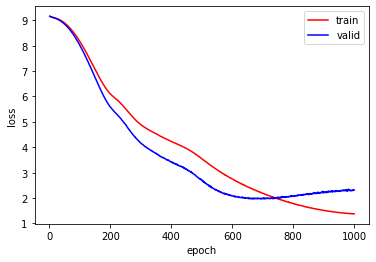

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

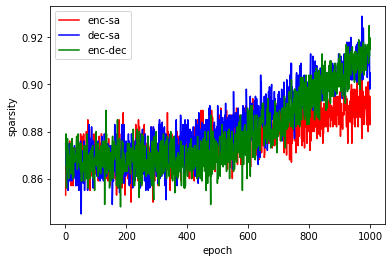

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')